# <span style="color:BLUE">  Step 2: Exploratory data analysis

In this notebook, we begin by loading the cleaned LendingClub dataset (`cleaned_lending_dataset.csv`) and proceed with a series of statistical analyses aimed at preparing the data for predictive modeling. The steps include:

1. Applying one-hot encoding to transform categorical variables into numerical format
2. Performing feature engineering to create new variables that better capture relationships in the data
3. Removing outliers to reduce bias and improve inference quality
4. Extracting insights from statistical patterns to guide model development
5. Identifying key variables that influence loan approval decisions
6. Save the new datasets 

**Output from this notebook**: A comprehensive data analysis summary that supports model development, informs business strategy, and highlights the most predictive features for loan approval.

**1. Loading the cleaned dataset**

In [327]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
file_name = "cleaned_lending_dataset.csv"
df = pd.read_csv(file_name)
df.head(5)

,fico_range_high,fico_range_low,pub_rec_bankruptcies,annual_inc,dti,home_ownership,loan_amnt,installment,verification_status,application_type,loan_status,total_acc,open_acc,bc_util,purpose,grade,term_numeric,int_rate_numeric
0,684.0,680.0,0.0,57000.0,25.33,RENT,24000.0,500.07,Source Verified,Individual,Current,24.0,10.0,40.5,credit_card,B,60.0,9.0
1,669.0,665.0,0.0,55000.0,7.22,MORTGAGE,5000.0,162.49,Not Verified,Individual,Fully Paid,9.0,7.0,54.8,credit_card,B,36.0,10.0
2,754.0,750.0,0.0,43500.0,24.55,MORTGAGE,24000.0,522.42,Not Verified,Individual,Current,23.0,15.0,12.0,debt_consolidation,B,60.0,11.0
3,739.0,735.0,0.0,48000.0,24.30,MORTGAGE,14000.0,322.79,Source Verified,Individual,Fully Paid,23.0,16.0,39.9,debt_consolidation,C,60.0,13.0
4,704.0,700.0,1.0,46000.0,11.56,RENT,4000.0,131.89,Verified,Individual,Charged Off,7.0,4.0,43.1,moving,B,36.0,11.0


In [328]:
# Separate object type (categorical/string) columns
df_catg = df.select_dtypes(include=['object'])

# Separate float type (numerical) columns
df_numeric = df.select_dtypes(include=['float64'])

# Check results
print("---------------------------------------")
print("Categorical columns:\n", df_catg.columns)
print("---------------------------------------")
print("Numeric columns:\n", df_numeric.columns)


---------------------------------------
Categorical columns:
 Index(['home_ownership', 'verification_status', 'application_type',
       'loan_status', 'purpose', 'grade'],
      dtype='object')
---------------------------------------
Numeric columns:
 Index(['fico_range_high', 'fico_range_low', 'pub_rec_bankruptcies',
       'annual_inc', 'dti', 'loan_amnt', 'installment', 'total_acc',
       'open_acc', 'bc_util', 'term_numeric', 'int_rate_numeric'],
      dtype='object')


**2. Cleaning the categorical data**



In [330]:
# Display counts of various categorical variables with bold headers
print("\n\033[1mCategories under Home Ownership:\033[0m")
print(df.home_ownership.value_counts())

print("\n\033[1mCategories under Verification Status:\033[0m")
print(df.verification_status.value_counts())

print("\n\033[1mCategories under Application Type:\033[0m")
print(df.application_type.value_counts())

print("\n\033[1mCategories under Loan Status:\033[0m")
print(df.loan_status.value_counts())

print("\n\033[1mCategories under Loan Purpose:\033[0m")
print(df.purpose.value_counts())

print("\n\033[1mCategories under Loan Grade:\033[0m")
print(df.grade.value_counts())



Categories under Home Ownership:
home_ownership
MORTGAGE    47744
RENT        38167
OWN         10958
ANY           124
OTHER           3
NONE            3
Name: count, dtype: int64

Categories under Verification Status:
verification_status
Source Verified    38052
Not Verified       35314
Verified           23633
Name: count, dtype: int64

Categories under Application Type:
application_type
Individual    90118
Joint App      6881
Name: count, dtype: int64

Categories under Loan Status:
loan_status
Fully Paid            49150
Current               34858
Charged Off           11978
Late (31-120 days)      525
In Grace Period         323
Late (16-30 days)        89
Issued                   63
Default                  13
Name: count, dtype: int64

Categories under Loan Purpose:
purpose
debt_consolidation    54129
credit_card           23574
home_improvement       6429
other                  5743
major_purchase         2098
medical                1117
small_business          979
car      

**Inference**: As evident from the categorical features `['home_ownership', 'verification_status', 'application_type', 'loan_status', 'purpose', 'grade']`, several subcategories within each can be meaningfully merged. Leveraging business intuition, we consolidate these labels to enhance clarity, improve visualization, and derive more actionable insights from the data. 

In [332]:
df['verification_status'] = df['verification_status'].replace({
    'Source Verified': 'Verified'
})
df['home_ownership'] = df['home_ownership'].replace({
    'OWN': 'Own House',
    'MORTGAGE': 'Own House',
    'RENT': 'Not Own House',
    'ANY' : 'Any',
    'OTHER': 'Any',
    'NONE': 'Any'
})

def recategorize_purpose(purpose):
    if purpose == 'debt_consolidation':
        return 'Debt Consolidation'
    elif purpose == 'credit_card':
        return 'Credit Card'
    elif purpose in ['home_improvement', 'major_purchase', 'medical', 'car', 'vacation', 'moving', 'wedding']:
        return 'Personal Loan'
    elif purpose == 'small_business':
        return 'Business'
    else:
        return 'Others'
        
df['purpose'] = df['purpose'].apply(recategorize_purpose)

def map_loan_status(status):
    if status in ['Current', 'Issued']:
        return 'Current'
    elif status == 'Fully Paid':
        return 'Fully Paid'
    else:
        return 'Defaulters'

df['loan_status'] = df['loan_status'].apply(map_loan_status)
print(df['loan_status'].value_counts())


loan_status
Fully Paid    49150
Current       34921
Defaulters    12928
Name: count, dtype: int64


In [333]:
# Display counts of various categorical variables with bold headers
print("\n\033[1mCategories under Home Ownership:\033[0m")
print(df.home_ownership.value_counts())

print("\n\033[1mCategories under Verification Status:\033[0m")
print(df.verification_status.value_counts())

print("\n\033[1mCategories under Application Type:\033[0m")
print(df.application_type.value_counts())

print("\n\033[1mCategories under Loan Status:\033[0m")
print(df.loan_status.value_counts())

print("\n\033[1mCategories under Loan Purpose:\033[0m")
print(df.purpose.value_counts())

print("\n\033[1mCategories under Loan Grade:\033[0m")
print(df.grade.value_counts())


Categories under Home Ownership:
home_ownership
Own House        58702
Not Own House    38167
Any                130
Name: count, dtype: int64

Categories under Verification Status:
verification_status
Verified        61685
Not Verified    35314
Name: count, dtype: int64

Categories under Application Type:
application_type
Individual    90118
Joint App      6881
Name: count, dtype: int64

Categories under Loan Status:
loan_status
Fully Paid    49150
Current       34921
Defaulters    12928
Name: count, dtype: int64

Categories under Loan Purpose:
purpose
Debt Consolidation    54129
Credit Card           23574
Personal Loan         11867
Others                 6450
Business                979
Name: count, dtype: int64

Categories under Loan Grade:
grade
B    28367
C    26665
A    21840
D    13739
E     4657
F     1337
G      394
Name: count, dtype: int64


**3. Data visualisation: Categorical data**

Among all the categorical variables, `loan_status` is particularly important as it reveals whether a borrower has defaulted on the `loan_amnt` or has successfully repaid it. To gain deeper insights, we will visualize each categorical variable in relation to the `loan_amnt` while observing the corresponding `loan_status`.

**Note**
The loan status to categorize the Fully Paid, Current and Charged-off.

- Defaulted Loan: A loan is considered in default when the borrower fails to make the required payments as agreed in the loan contract. Default typically occurs after missing several payments (usually 90 to 180 days, depending on the type of loan and lender policies).
- A loan is charged off when the lender writes off the loan as a bad debt on their financial statements, recognizing it as a loss. This typically happens after the loan has been in default for a significant period, often around 180 days.

**1. Home ownership**

Text(0, 0.5, 'Loan status')

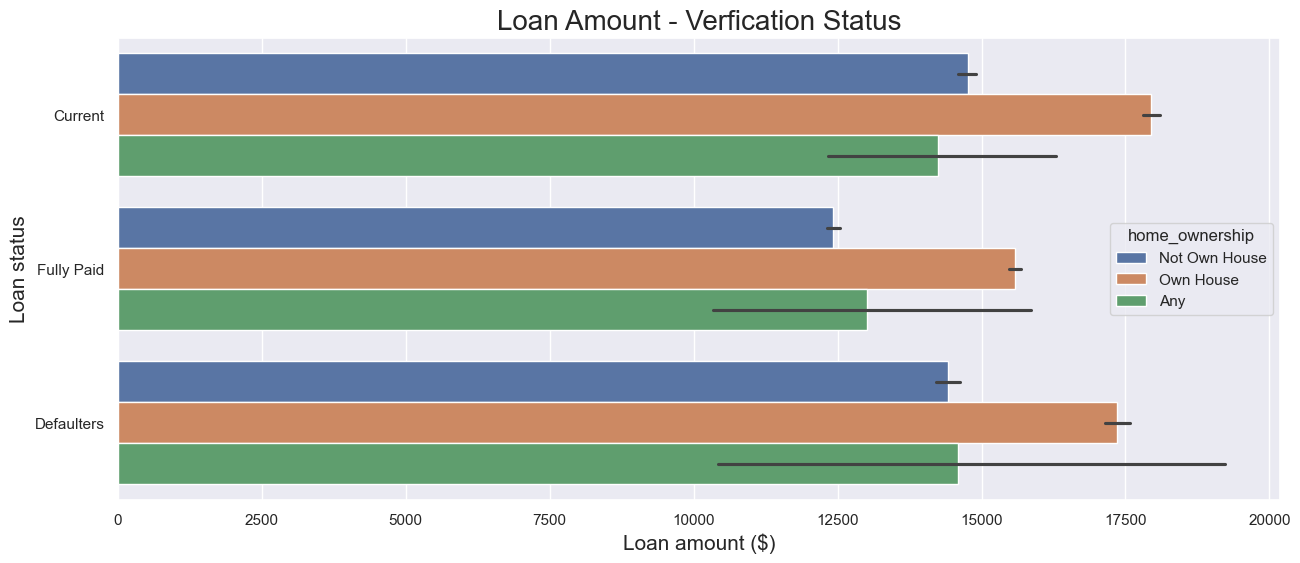

In [337]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'loan_amnt', y = 'loan_status', 
            hue = 'home_ownership',
            data = df)
plt.title("Loan Amount - Verfication Status", fontsize=20)
plt.xlabel("Loan amount ($)", fontsize=15)
plt.ylabel("Loan status", fontsize=15)

Individuals who own a house are typically granted higher loan amounts—often exceeding \$14,000. However, there's an ambiguous category labeled "Any," which shows high variability in loan amounts and a greater likelihood of default. Overall, it's evident that borrowers who own a home tend to have a lower risk of default.

**2. Verification status**

Text(0, 0.5, 'Loan status')

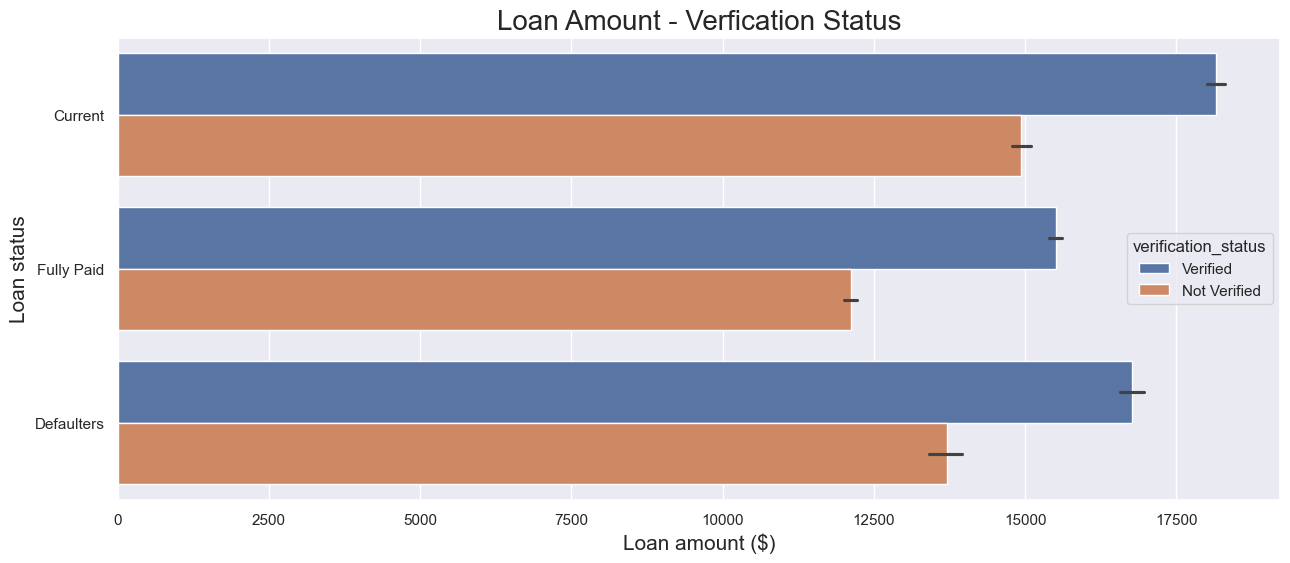

In [340]:
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'loan_amnt', y = 'loan_status', 
            hue = 'verification_status',
            data = df)
plt.title("Loan Amount - Verfication Status", fontsize=20)
plt.xlabel("Loan amount ($)", fontsize=15)
plt.ylabel("Loan status", fontsize=15)

Loans are issued to individuals regardless of whether their identities are verified. However, verified individuals tend to receive loans exceeding $15,000, and the likelihood of default appears to be higher among those who are not verified.

**3. Loan Purpose**

Text(0, 0.5, 'Loan status')

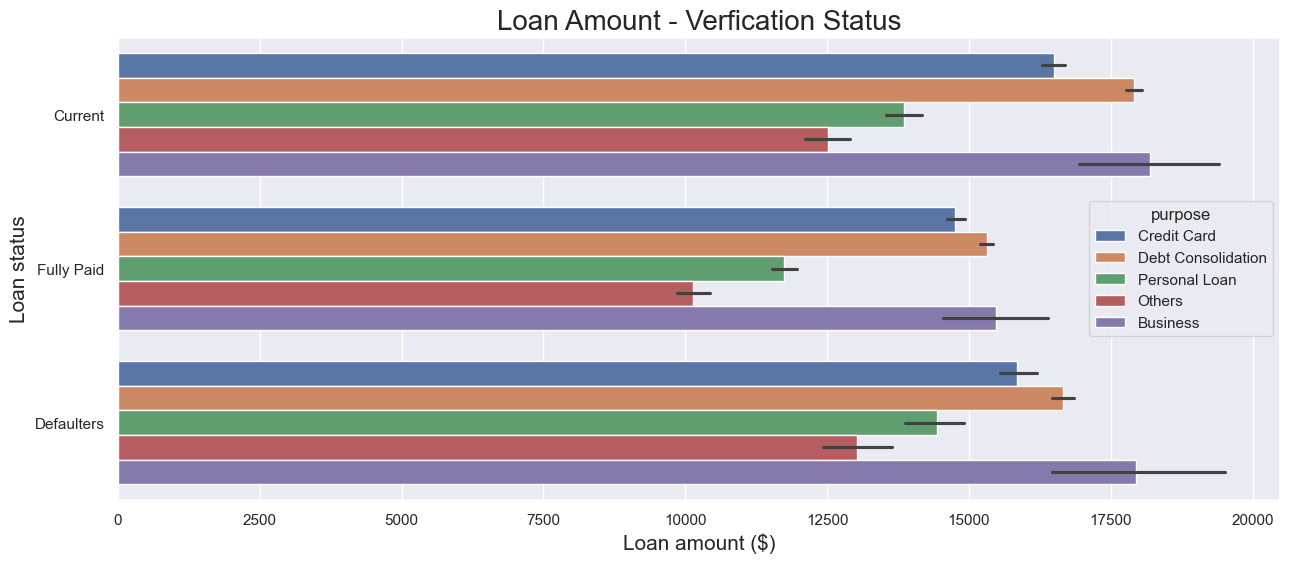

In [343]:
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'loan_amnt', y = 'loan_status', 
            hue = 'purpose',
            data = df)
plt.title("Loan Amount - Verfication Status", fontsize=20)
plt.xlabel("Loan amount ($)", fontsize=15)
plt.ylabel("Loan status", fontsize=15)

The highest loan amounts are typically borrowed for Business purposes, followed by Debt Consolidation, Credit Card, Personal Loans, and Other categories. We'll visualize this trend using a bar plot for better clarity. 

Interpreting the relationship between loan status and purpose isn't entirely straightforward. However, a comparison between the "Fully Paid" and "Defaulted" categories suggests that higher loan amounts—regardless of purpose—tend to have a greater likelihood of default.

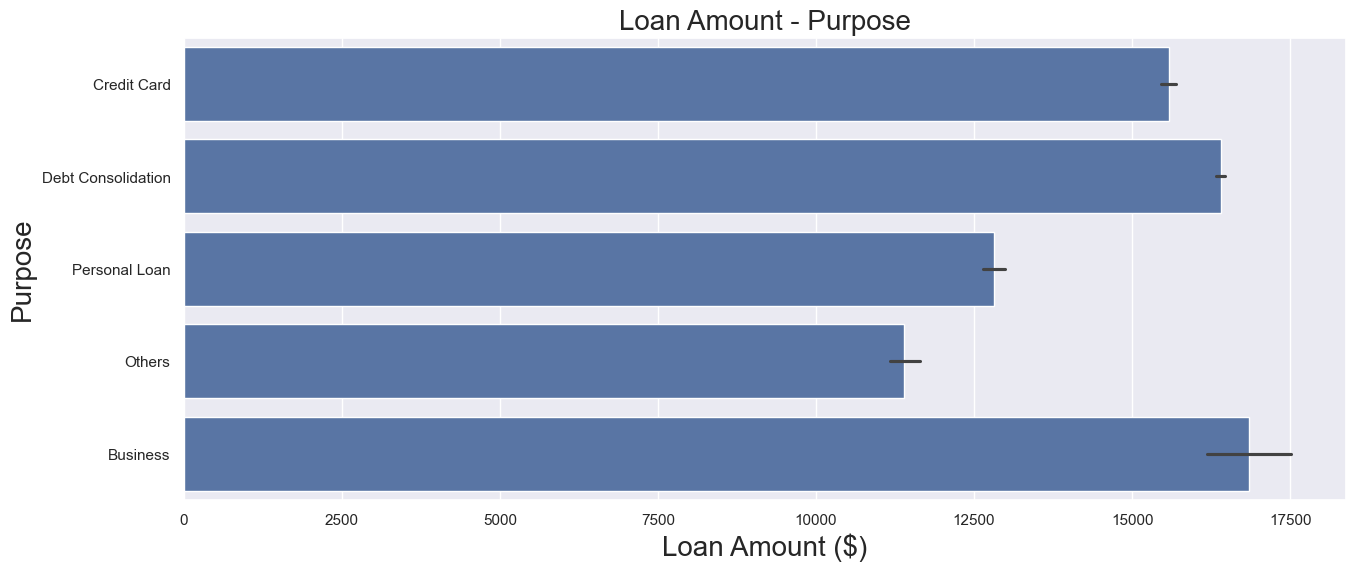

In [345]:
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(y = 'purpose', x = 'loan_amnt', data = df)
plt.title("Loan Amount - Purpose", fontsize=20)
plt.ylabel("Purpose", fontsize=20)
plt.xlabel("Loan Amount ($)", fontsize=20);
plt.show()

**4. Loan grade**

Text(0, 0.5, 'Loan status')

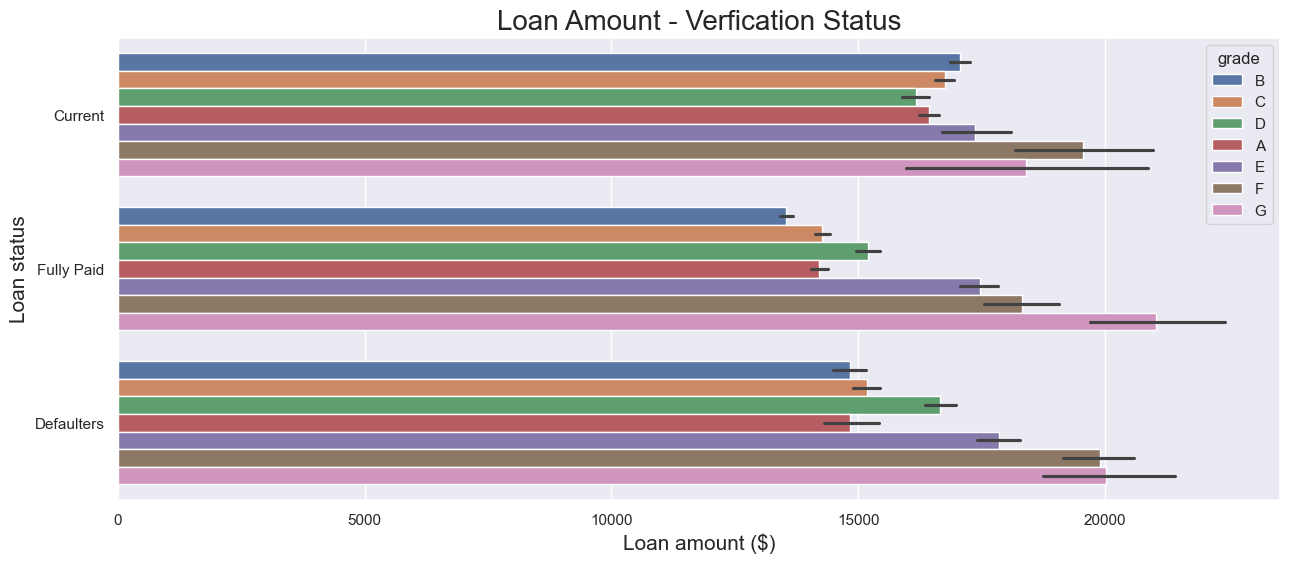

In [347]:
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'loan_amnt', y = 'loan_status', 
            hue = 'grade',
            data = df)
plt.title("Loan Amount - Verfication Status", fontsize=20)
plt.xlabel("Loan amount ($)", fontsize=15)
plt.ylabel("Loan status", fontsize=15)

The plot is difficult to interpret, but its certainly apparent that the loan amount is categorize under based on the loan amount. It's clear infer any relation with the loan status. Let's check whether the grade is related to the loan purpose.

Text(0, 0.5, 'Loan Grade')

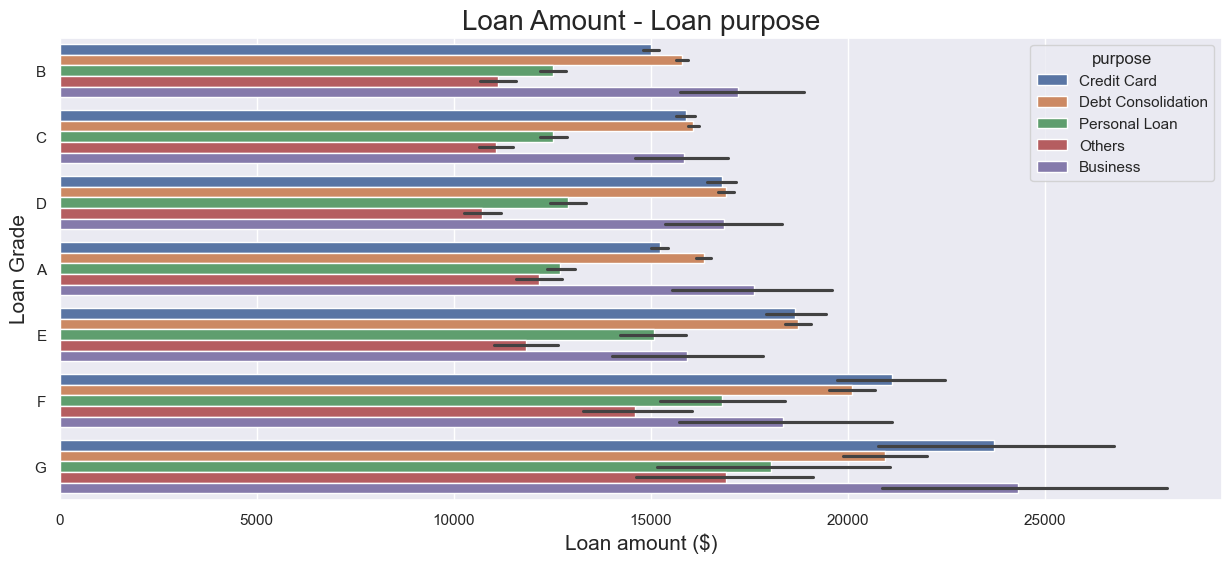

In [349]:
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'loan_amnt', y = 'grade', 
            hue = 'purpose',
            data = df)
plt.title("Loan Amount - Loan purpose", fontsize=20)
plt.xlabel("Loan amount ($)", fontsize=15)
plt.ylabel("Loan Grade", fontsize=15)

**We check the relation of the loan grade with the interest rate and loan amount**

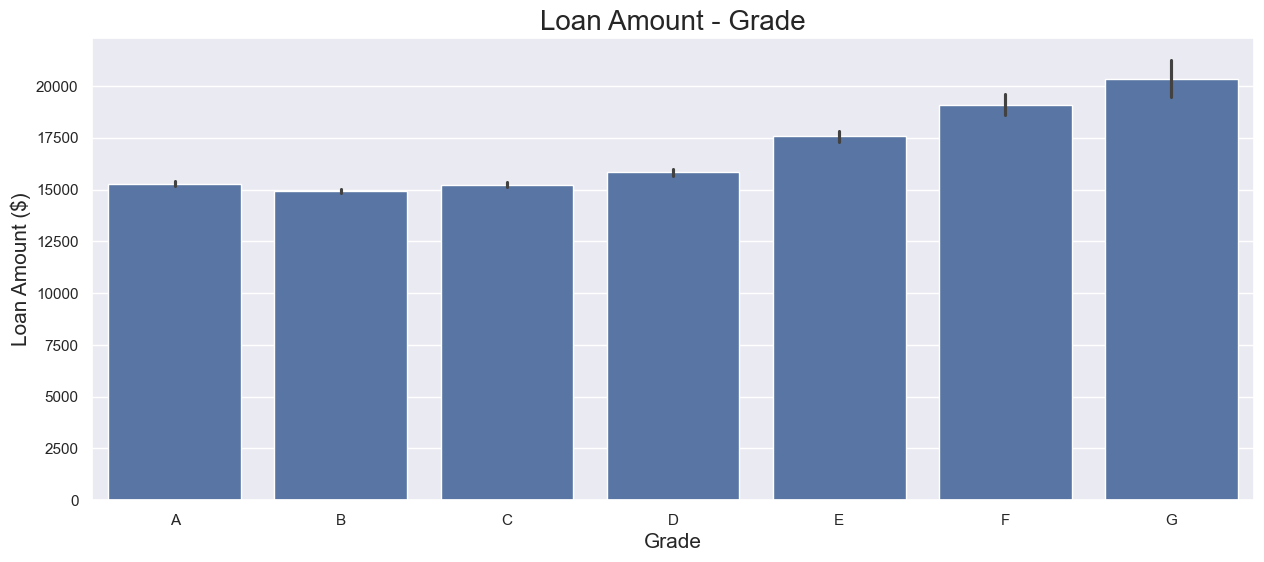

--------------------------------------


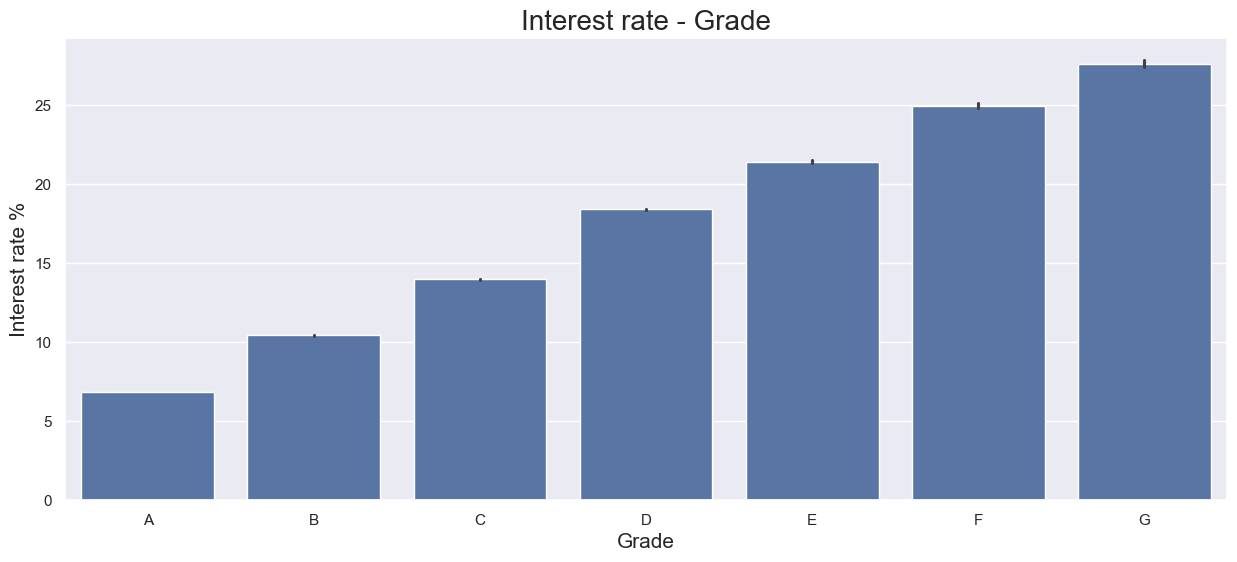

In [351]:
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'grade', y = 'loan_amnt', data = df, order="ABCDEFG")
plt.title("Loan Amount - Grade", fontsize=20)
plt.xlabel("Grade", fontsize=15)
plt.ylabel("Loan Amount ($)", fontsize=15);
plt.show()
print("--------------------------------------")
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'grade', y = 'int_rate_numeric', data = df, order="ABCDEFG")
plt.title("Interest rate - Grade", fontsize=20)
plt.xlabel("Grade", fontsize=15)
plt.ylabel("Interest rate %", fontsize=15);
plt.show()

The `grade` column is assigned based on the average loan amount. For instance, loans in grade `A` typically average around \$15,000, while those in grade `G` average around \$20,000—suggesting that higher grades correspond to higher loan amounts. However, the mean loan amounts for grades `A`, `B`, and `C` are quite similar. To further investigate, we plot the `interest rate` against the `grade`, which reveals a clearer relationship: the grades are actually categorized in ascending order of the `interest rate`.

**5. Application type**

Text(0, 0.5, 'Loan status')

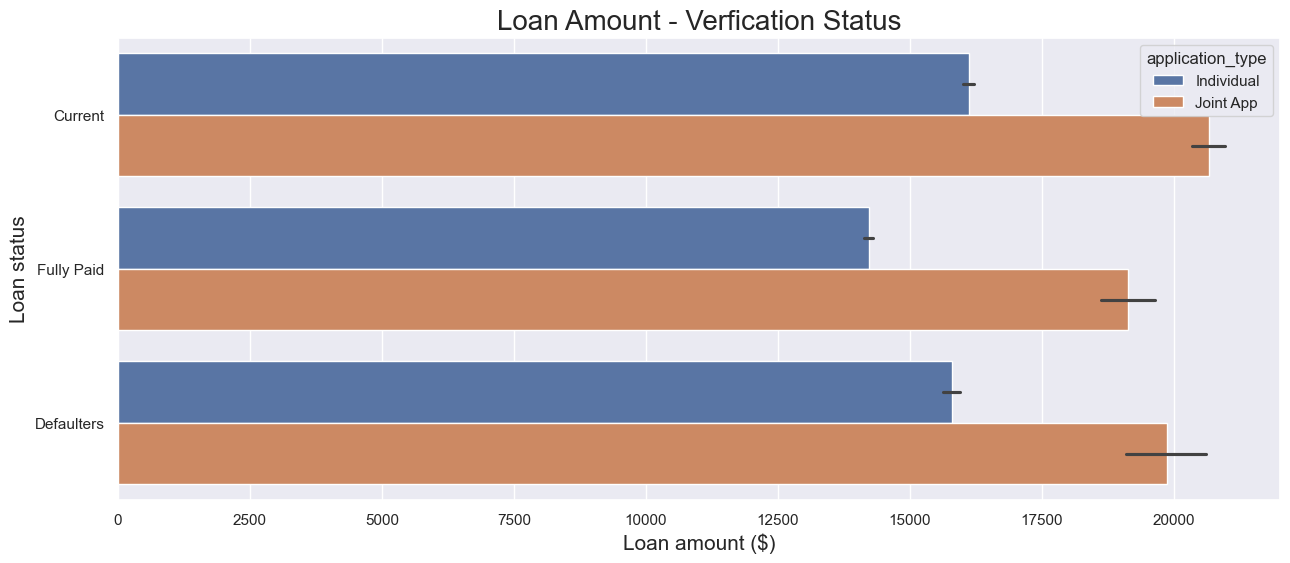

In [354]:
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'loan_amnt', y = 'loan_status', 
            hue = 'application_type',
            data = df)
plt.title("Loan Amount - Verfication Status", fontsize=20)
plt.xlabel("Loan amount ($)", fontsize=15)
plt.ylabel("Loan status", fontsize=15)

It is evident that higher loan amounts were granted to applicants with joint applications. Notably, defaults are more common among borrowers who received larger loans—specifically, amounts exceeding 16,000 USD for individual applicants and over 18,000 USD for joint applicants.

**3. Data visualisation: Numeric data**

In [357]:
# Descriptive statistics of the numeric columns
print("\nDescriptive Statistics:")
df.describe().apply(lambda x: x.apply('{0:.2f}'.format))


Descriptive Statistics:


,fico_range_high,fico_range_low,pub_rec_bankruptcies,annual_inc,dti,loan_amnt,installment,total_acc,open_acc,bc_util,term_numeric,int_rate_numeric
count,96999.00,96999.00,96999.00,96999.00,96999.00,96999.00,96999.00,96999.00,96999.00,96999.00,96999.00,96999.00
mean,704.40,700.40,0.13,80421.66,19.44,15432.75,454.63,24.13,11.79,55.84,43.14,12.53
std,33.69,33.69,0.36,87888.18,17.34,9476.46,273.26,12.07,5.76,28.84,10.97,4.87
min,664.00,660.00,0.00,0.00,-1.00,1000.00,30.12,2.00,1.00,0.00,36.00,5.00
25%,679.00,675.00,0.00,48000.00,12.15,8000.00,256.04,15.00,8.00,32.70,36.00,9.00
50%,699.00,695.00,0.00,67000.00,18.20,13200.00,383.00,22.00,11.00,57.30,36.00,12.00
75%,724.00,720.00,0.00,95500.00,25.01,20275.00,607.19,31.00,15.00,81.20,60.00,16.00
max,850.00,845.00,7.00,10999200.00,999.00,40000.00,1719.83,115.00,86.00,175.00,60.00,30.00


	

| Feature | Insight |
|--------|---------|
| `fico_range_high`, `fico_range_low` | FICO scores range between 660–850, with a median of ~700. |
| `pub_rec_bankruptcies` | Mostly 0 (75% percentile is 0), but up to 7 existfor this feature. |
| `annual_inc` | Wide income range (up to 11 M USD), median is 67 USD, mean is 80K USD — **long right tail**, so consider **log transformation**. |
| `dti` | Mostly within a normal range (median 18), but some extreme outliers (max 999, likely invalid/missing). |
| `loan_amnt`, `installment` | Median loan is \$13K with corresponding installments — expected positive correlation. |
| `total_acc`, `open_acc` | Number of accounts range widely (2–115), average is moderate. Could help with credit history depth. |
| `bc_util` | Revolving utilization ratio median ~57%, could be a good indicator of financial pressure. |
| `term_numeric` | Only two values (36 and 60 months), already numeric — a binary flag could be used for `long_term`. |
| `int_rate_numeric` | Interest rates between 5%–30%, median ~12% — strongly tied to credit risk level.

--

**Correlation heatmap of numeric variables**

The dependence between the individual variables are clear from the heat map plot

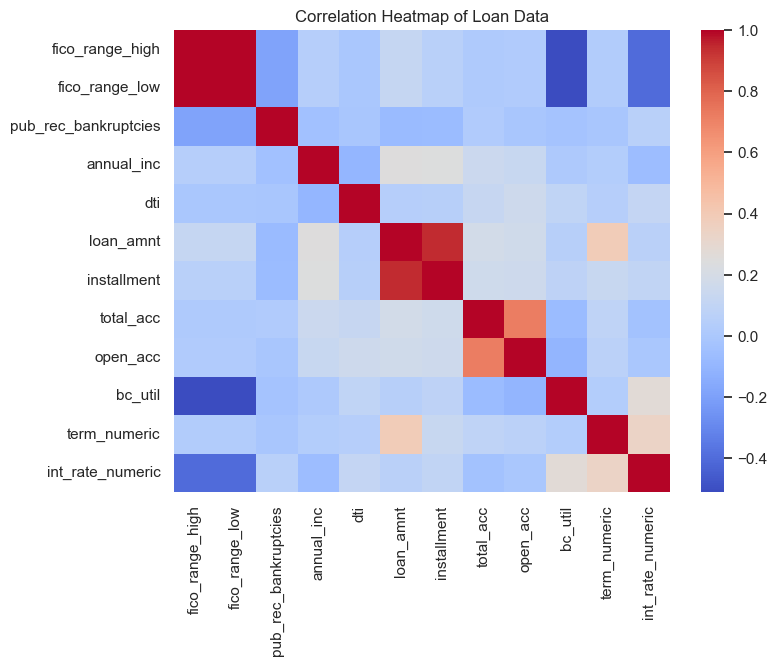

In [360]:
df_numeric = df.select_dtypes(include=['number']) #Select only numeric data
corr_matrix = df_numeric.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap of Loan Data")
plt.savefig("Image.png")
plt.show()

<span style = "color: Blue">**Correlation heatmap** that represents the relationship between different numerical variables in a loan dataset. The color scale on the right indicates correlation values, ranging from **-1 (strong negative correlation, blue)** to **+1 (strong positive correlation, red)**. 

**High Positive Correlation (Red Cells)**

- loan_amnt and installment (~1.0): larger loans result in higher monthly payments
- fico_range_high and fico_range_low (~1.0): These are essentially two measures of the same thing; can be merged or one dropped
- total_acc and open_acc (~0.5–0.6): Indicates current open accounts are a good proportion of total accounts
- int_rate is higher for high bc_util and term_numeric
- annual_inc and loan_amnt
- loan_amnt and duraction

**Negative Correlation (Blue Cells)**

- fico_range_low and bc_util (~ -0.4): As utilization increases, credit score drops — a well-known financial trend.
- int_rate_numeric negatively correlated with fico_range_high/low
- Higher interest rate imply lower creditworthiness

We can merge `fico_score` and drop `open_acc`.

**6. Feautre Engineering** 

Based on our observation on the heatmap, we make a new feautre:
- `fico_score` which is essentially mean of `fico_range_high` and `fico_range_low`
- `loan_income_ratio` which is ratio of `loan_amnt` to `annual_inc`
- `loan_term_ratio`, which is rartio of `loan_amnt` to `installments`
-  `bc_util_flag`, `df['high_util_flag'] = df['bc_util'] > 75` 

In [363]:
df['fico_score'] = (df['fico_range_high'] + df['fico_range_low']) / 2
df['loan_income_ratio'] = df['loan_amnt']/ df['annual_inc']
df['loan_term_ratio'] = df['loan_amnt'] / df['installment']
df['high_util_flag'] = df['bc_util'] > 75 #Binary True of False

Lets drop redundant columns, this will make our model computatonaly efficient.

In [365]:
drop_column_list = ["fico_range_high", "fico_range_low", "installment", "bc_util", "open_acc"]
df_clean = df.drop(drop_column_list, axis = 1)

In [366]:
# Show number of features of df_clean
print("---------------------------------------------\n")
print(f"Number of features (columns): {df_clean.shape[1]}\n")
# Show feature names and their types
print("---------------------------------------------\n")
print("Feature names and data types:\n")
print(df_clean.dtypes)
print("---------------------------------------------\n")

# Optional: count of data types
print("Summary of data types:\n")
print(df_clean.dtypes.value_counts())
print("---------------------------------------------\n")

---------------------------------------------

Number of features (columns): 17

---------------------------------------------

Feature names and data types:

pub_rec_bankruptcies    float64
annual_inc              float64
dti                     float64
home_ownership           object
loan_amnt               float64
verification_status      object
application_type         object
loan_status              object
total_acc               float64
purpose                  object
grade                    object
term_numeric            float64
int_rate_numeric        float64
fico_score              float64
loan_income_ratio       float64
loan_term_ratio         float64
high_util_flag             bool
dtype: object
---------------------------------------------

Summary of data types:

float64    10
object      6
bool        1
Name: count, dtype: int64
---------------------------------------------



**7. Data visualization with new feautres**

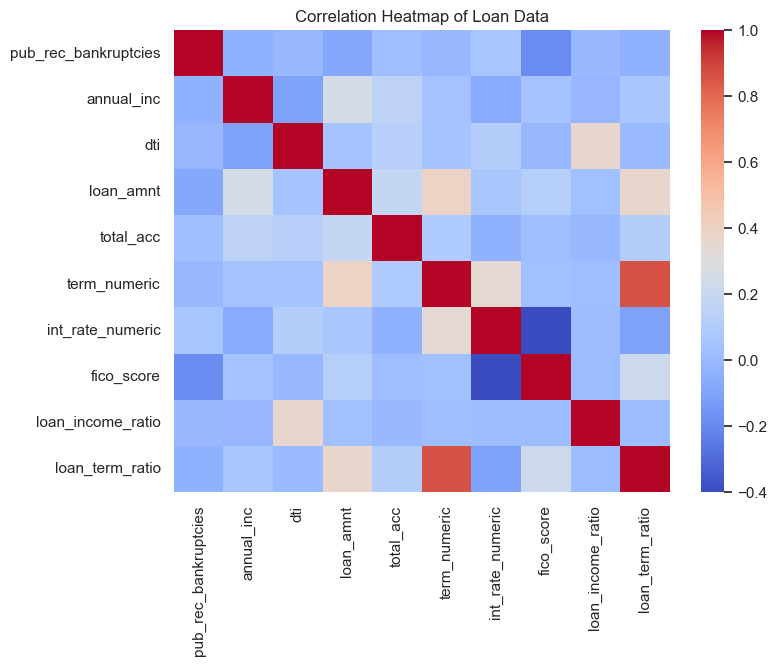

In [368]:
#Heat map
df_numeric_clean = df_clean.select_dtypes(include=['number']) #Select only numeric data
corr_matrix_clean = df_numeric_clean.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_clean, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap of Loan Data")
plt.show()

<span style = "color: Blue">**Correlation heatmap** that represents the relationship between different numerical variables in a loan dataset. The color scale on the right indicates correlation values, ranging from **-1 (strong negative correlation, blue)** to **+1 (strong positive correlation, red)**. 

**High Positive Correlation (Red Cells)**

- loan_term_ratio and loan and terms 
- loan_income_ratio and dti (smilar to debt to income ratio)

**Negative Correlation (Blue Cells)**

- fico_score and pub_rec_bankruptcies, int_rate (~ -0.4): Low credit score higher chance of backruptcies
- loan_term_ratio and int_rate (~ -0.2)


**8. Visualize the `high_util_flag`**

Text(0, 0.5, 'Loan status')

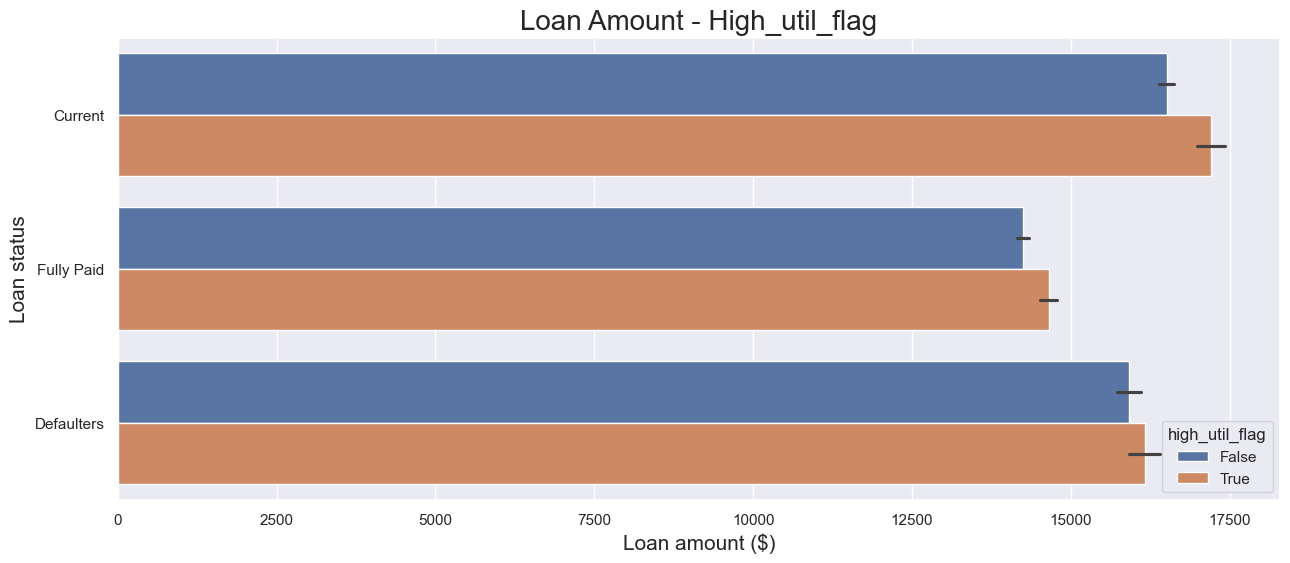

In [371]:
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'loan_amnt', y = 'loan_status', 
            hue = 'high_util_flag',
            data = df_clean)
plt.title("Loan Amount - High_util_flag", fontsize=20)
plt.xlabel("Loan amount ($)", fontsize=15)
plt.ylabel("Loan status", fontsize=15)

Individuals flagged with high credit card utilization (`True`) tend to receive larger loan amounts. However, it's important to note that **loan status is more strongly influenced by the loan amount itself** than by utilization alone.

**9. Handling outliers**

**Plots feautres with high variances**

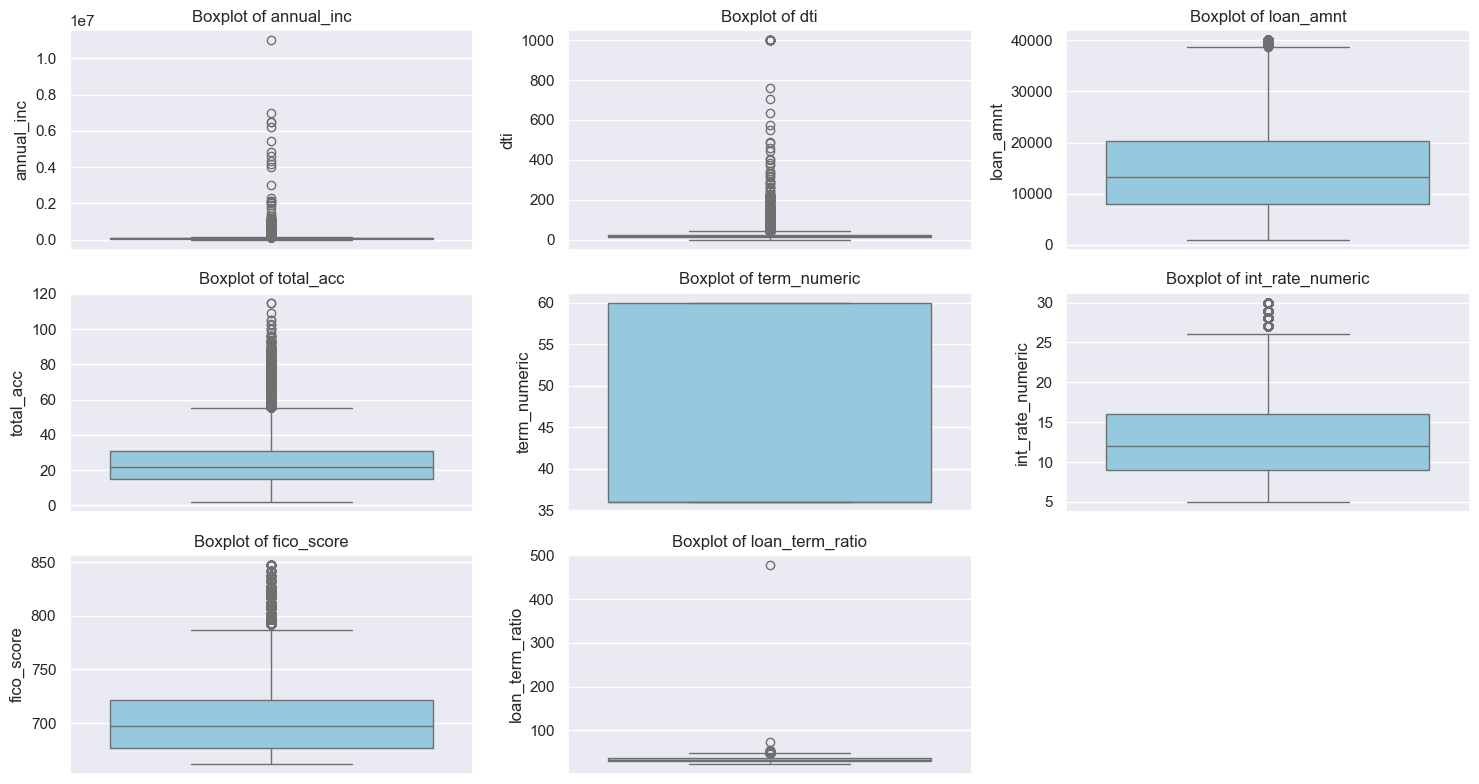

In [375]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df_clean.select_dtypes(include='number')
features_to_plot = numeric_cols.loc[:, numeric_cols.var() > 1.0].columns.tolist() #Plots feautres with high variances

plt.figure(figsize=(15, 8))
for i, col in enumerate(features_to_plot, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df_clean[col], color='skyblue')
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.savefig("Image.png")
plt.show()


Boxplots provide a visual summary of the **distribution and outliers** in numeric features from the LendingClub loan dataset. 

---
Each boxplot shows:
- **Box** = Interquartile range (IQR) from 25th percentile (Q1) to 75th percentile (Q3)
- **Line in the box** = Median (Q2)
- **Dots above/below whiskers** = Outliers (typically > 1.5×IQR)
- For feautres - `annual_inc` and `dti` min, max and median is not clear. Therefore, we will apply `log1p()` transform for normalization (log(1 + income)).


/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


-------------------------------
Plot the box plot in the log scale for clear visualisation of outliers


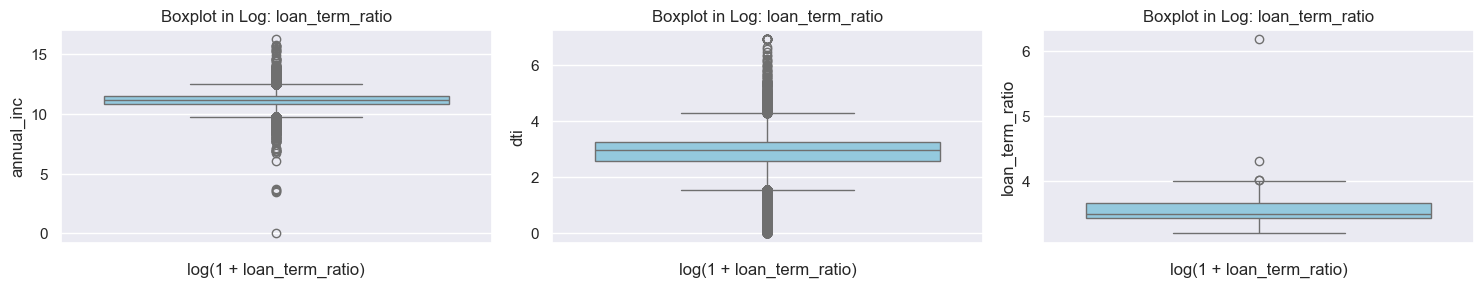

In [377]:
# Choose features to log-transform (add a small value to avoid log(0))
features = ['annual_inc', 'dti', 'loan_term_ratio']
df_log = df_clean.copy()
df_log[features] = df_log[features].apply(lambda x: np.log1p(x))  # log1p(x) = log(1 + x)

# print(f"Plot the hostograms in the log scale for clear visualisation of outliers")
# # Plotting
# fig, axs = plt.subplots(1, 3, figsize=(18, 5))
# for i, feature in enumerate(features):
#     sns.histplot(df_log[feature], ax=axs[i], kde=True)
#     axs[i].set_title(f'Log Distribution: {feature}')
#     axs[i].set_xlabel(f'log(1 + {feature})')

# plt.tight_layout()
# plt.show()

print("-------------------------------")
print(f"Plot the box plot in the log scale for clear visualisation of outliers")

plt.figure(figsize=(15, 8))
for i, col in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df_log[col], color='skyblue')
    plt.title(f"Boxplot in Log: {feature}")
    plt.xlabel(f'log(1 + {feature})')
plt.tight_layout()
plt.show()

In the logarthimic represention mean, 1st quartile and 3rd quartile are clearly visible.

**Cap outliers at the 95th percentile to limit extreme values**

[fico_score] Capping at 95th percentile value: 772.00
Max Z-score after capping [fico_score]: 2.28


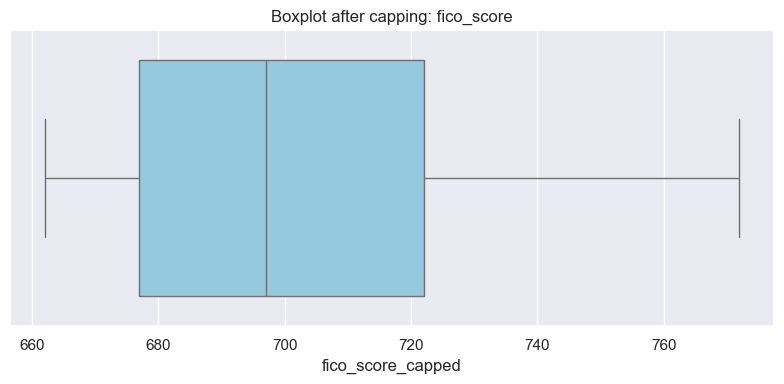

[annual_inc] Capping at 95th percentile value: 170000.00
Max Z-score after capping [annual_inc]: 2.45


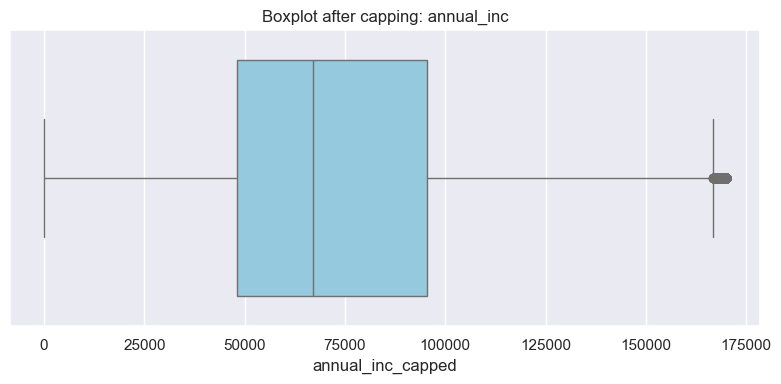

[dti] Capping at 95th percentile value: 34.72
Max Z-score after capping [dti]: 2.28


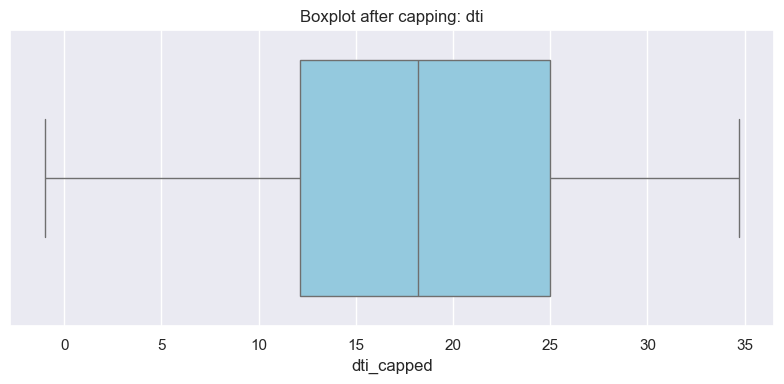

[loan_term_ratio] Capping at 95th percentile value: 46.00
Max Z-score after capping [loan_term_ratio]: 2.15


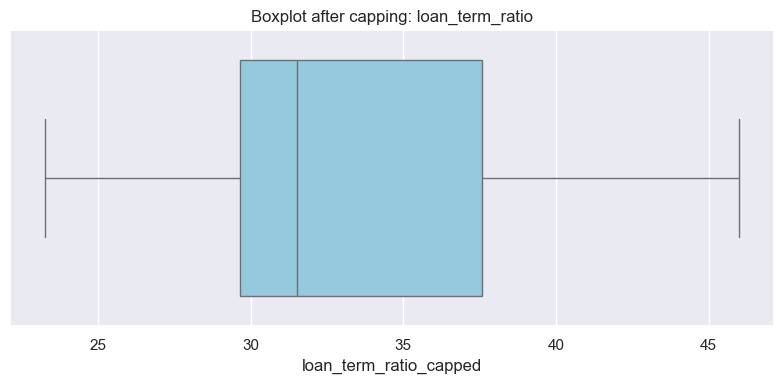

[int_rate_numeric] Capping at 95th percentile value: 22.00
Max Z-score after capping [int_rate_numeric]: 2.13


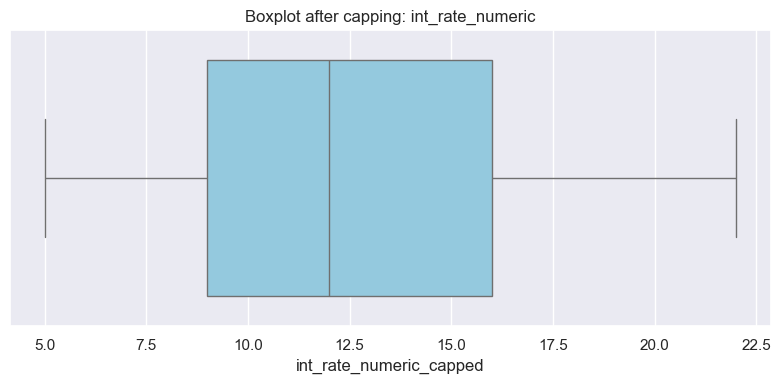

[loan_amnt] Capping at 95th percentile value: 35000.00
Max Z-score after capping [loan_amnt]: 2.15


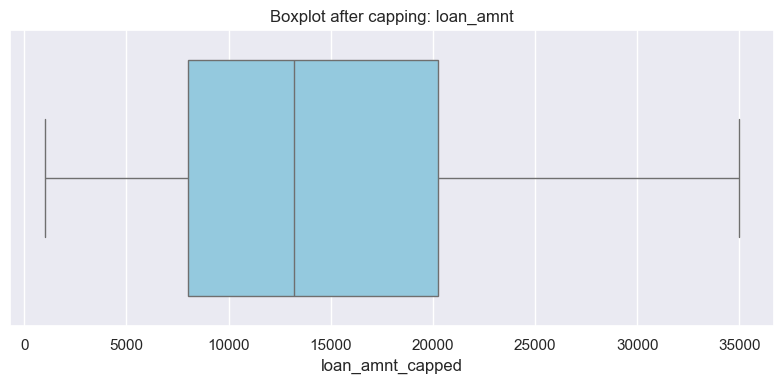

In [380]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Feautres to cap
fields_to_treat = ["fico_score", "annual_inc", "dti", "loan_term_ratio", "int_rate_numeric", "loan_amnt"]

# Visualize each feature
for field in fields_to_treat:
    capped_field = f"{field}_capped"
    
    # Compute the 95th percentile 
    cap_value = numerical_df[field].quantile(0.95)
    print(f"[{field}] Capping at 95th percentile value: {cap_value:.2f}")
    
    # Apply capping and update the dataframe
    numerical_df[capped_field] = np.where(numerical_df[field] > cap_value, cap_value, numerical_df[field])
    
    # Z-score
    max_zscore = max(np.abs(stats.zscore(numerical_df[capped_field])))
    print(f"Max Z-score after capping [{field}]: {max_zscore:.2f}")
    
    # Show boxplots
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=numerical_df[capped_field], color="skyblue")
    plt.title(f"Boxplot after capping: {field}")
    plt.tight_layout()
    plt.show()


**Our updated dataframe:** 

`numerial_df` - contains all numerical collumns
`df_clean` - contains all feautres

In [382]:
# Ensure the indices align before merging
df_clean.update(numerical_df)
df_clean = pd.concat([df_clean, numerical_df[[col for col in numerical_df.columns if col not in df_clean.columns]]], axis=1)

**10 Identifying key variables that influence loan approval decisions** 

All the key variables that are important for the deciding the loan approval are here

In [418]:
# Separate object type (categorical/string) columns
df_catg = df_clean.select_dtypes(include=['object'])

# Separate float type (numerical) columns
df_numeric = df_clean.select_dtypes(include=['float64'])

# Check results
print("---------------------------------------")
print("Categorical columns:\n", df_catg.columns)
print("---------------------------------------")
print("Numeric columns:\n", df_numeric.columns)


---------------------------------------
Categorical columns:
 Index(['loan_status'], dtype='object')
---------------------------------------
Numeric columns:
 Index(['pub_rec_bankruptcies', 'total_acc', 'term_numeric',
       'loan_income_ratio', 'fico_score_capped', 'annual_inc_capped',
       'dti_capped', 'loan_term_ratio_capped', 'int_rate_numeric_capped',
       'loan_amnt_capped'],
      dtype='object')


---
**Insights**
Based on our Exploratory Data Analysis (EDA), we identify **`loan_status`** as a key variable for indicating the decision of loan approval. It effectively captures critical aspects such as **loan performance** and **credit risk**, making it a strong candidate for the **target variable** in our predictive model.

All other variables will serve as **input features** to help predict `loan_status`. In the context of data science, `loan_status` is the **dependent variable**, while the remaining features act as **independent variables**.

Furthermore, we drop other categorical variables, as they do not significantly influence loan approval decisions. Instead, these variables offer general insights into borrower characteristics but do not directly contribute to the prediction outcome.

In [386]:
columns_to_drop = ['home_ownership', 'verification_status', 'application_type', 'purpose', 'grade', 'dti', "fico_score", "annual_inc", "loan_term_ratio", "int_rate_numeric", "loan_amnt"]
df_clean = df_clean.drop(columns_to_drop, axis = 1)

**10. Save the cleaned dataset with newly engineered features and capped outliers**

In [388]:
filename = "EDA_cleaned_lending_dataset.csv"

df_clean.to_csv(filename, index=False)

print(f"DataFrame saved to '{filename}'")
print("-----------------------------------")
print(f"Cleaned datasets is saved!")

DataFrame saved to 'EDA_cleaned_lending_dataset.csv'
-----------------------------------
Cleaned datasets is saved!


### Summary:

1. Data visualization with categorical variables as a function of loan amount
2. Performed feature engineering and added variables: `fico_score`, `loan_income_ratio`, `loan_term_ratio`, `bc_util_flaf`
3. Extracting insights from statistical patterns: numerical and categorical plots both were discussed.
4. Removing outliers to reduce bias and improve inference quality: capped at 95th percentile
5. Identifying key variables that influence loan approval decisions
6. Saved the new dataset wtih name `EDA_cleaned_lending_dataset.csv`

